In [401]:
import os
import sys

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew

In [331]:
class CNNModule(nn.Module):
    def __init__(self, sequence_shape, kernel_size=10, base_channel=64, module_count=2, pooling_coef=2,
                 cnn_padding='same', padding_mode = 'zeros', channel_multiplier=2, act_fn='relu'):
        assert pooling_coef*base_channel == int(pooling_coef*base_channel)
        act_func_dict = {
                            'relu':nn.ReLU(inplace = True), 
                            'selu':nn.SELU(inplace = True),
                            'elu':nn.ELU(inplace = True),
                        }
        super().__init__()
        self.sequence_shape = sequence_shape # (channel, length) tuple
        self.kernel_size = kernel_size
        self.base_channel = base_channel
        self.module_count = module_count
        self.pooling_coef = pooling_coef
        self.padding_mode = padding_mode
        self.cnn_padding = cnn_padding
        self.channel_multiplier = channel_multiplier
        self.act_fn = act_func_dict[act_fn]
        
        self.model = self.build()
        
        
    def build(self):
        channel = self.base_channel
        length = self.sequence_shape[1]
        model = [nn.Conv1d(in_channels = self.sequence_shape[0], out_channels = channel, kernel_size = self.kernel_size,
                          padding = self.cnn_padding, padding_mode = self.padding_mode),
                self.act_fn]
        
        priv_channel = channel
        channel *= self.channel_multiplier
        
        for _ in range(self.module_count):
            model += [
                nn.Conv1d(in_channels=priv_channel, out_channels=channel, kernel_size=self.kernel_size, 
                            padding='same', padding_mode=self.padding_mode),
                self.act_fn,
                nn.Conv1d(in_channels=channel, out_channels=channel, kernel_size=self.kernel_size, 
                            padding='same', padding_mode=self.padding_mode),
                self.act_fn,
                nn.BatchNorm1d(length),
                nn.MaxPool1d(2, stride=2)
            ]
        
            length = int(length/2)
            priv_channel = channel
            channel *= self.channel_multiplier
            
        return nn.Sequential(*model)
        

    def forward(self, x):
        return self.model(x)
    
    
class StatAnalModule(nn.Module):
    def __init__(self, length, complexity = 2):
        super().__init__()
        self.length = length
        self.complexity = complexity
        
    def moment(self, x, order):
        return torch.sum(torch.pow((x - torch.mean(x,-1).reshape(-1, 1)/torch.std(x, -1)), order) ,-1)
        
    def forward(self, x):
        result = torch.cat([torch.mean(x, -1), torch.max(x, -1)[0], torch.min(x, -1)[0], \
                            torch.sqrt(torch.mean(torch.pow(x, 2), -1)), torch.var(x, -1)])
        if self.complexity > 0:
            skew = self.length/(self.length-1)/(self.length-2)*torch.sum( torch.pow(x - torch.mean(x,-1).reshape(-1, 1), 3) ,-1)/\
                            torch.var(x, -1)
            kurto = 1/(self.length-2)/(self.length=3) * \
                
            
            result = torch.cat([result, skew, kurto])

        
        return result
    

    
def call(self, inputs):
      mean = tf.reduce_mean(inputs,axis = 1)
      max = tf.reduce_max(inputs,axis = 1)
      min = tf.reduce_min(inputs,axis = 1)
      RMS = tf.math.sqrt(tf.reduce_mean(tf.math.exp(inputs),axis = 1))
      var = tf.math.reduce_variance(inputs,axis = 1)
      #Skew = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),3),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),3)
      #Kurto = tf.reduce_sum(tf.pow(tf.math.exp(inputs) - tf.expand_dims(tf.reduce_mean(inputs,axis = 1), axis = 1),4),axis =1)/self.length_of_signal/tf.pow(tf.math.reduce_std(inputs,axis = 1),4) 
      #ShapeFactor = RMS*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      #CrestFactor = tf.reduce_max(tf.abs(inputs),axis = 1)/RMS
      #ImpulseFactor = tf.reduce_max(tf.abs(inputs),axis = 1)*self.length_of_signal/tf.reduce_sum(tf.abs(inputs),axis = 1)
      # be aware of broadcasting
      return tf.stack([mean,max,min,RMS,var],axis = 1)

In [332]:
data = torch.rand(1,128)
model = CNNModule((1,128))

In [333]:

length =128

In [417]:
ske = []
kur = []
realske = []
realkur = []
statts = StatAnalModule(128) 

for i in range(1000):
    a = np.random.randn(1,128)
    x= torch.Tensor(a)
    result1 = statts(x) # 평균, 최대 최소 rms 분산 왜도 첨도
    result2 = [a.mean(), a.max(), a.min(), 1, a.std(), skew(a, -1), kurtosis(a, -1)]
    kur.append((result2[-1]/result1[-1]).numpy())
    ske.append((result2[-2]/result1[-2]).numpy())
    realske.append(result2[-1])
    realkur.append(result2[-2])
    #for item in zip(result1.numpy(), result2):
        #print(item, item[0]/item[1])
     #   ske.append(item[0])
     #   kur.append(item[1])

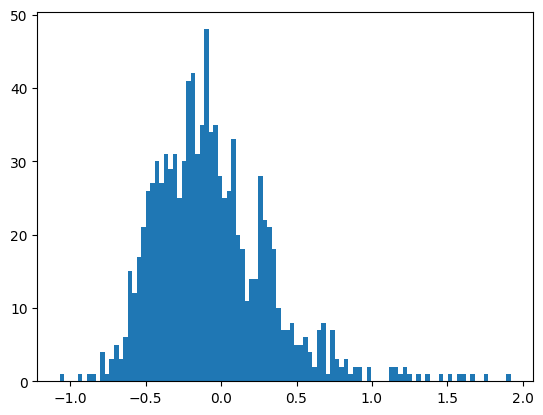

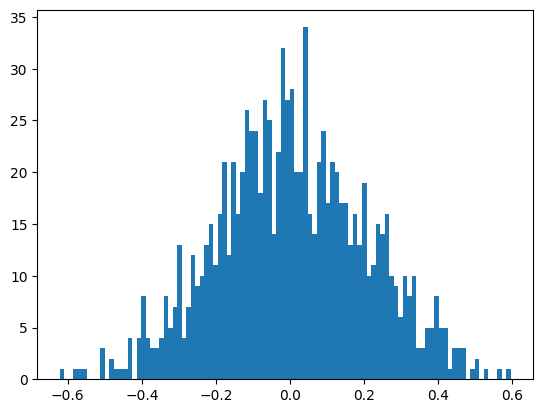

In [418]:
plt.hist(np.array(realske), bins = 100)
plt.show()
plt.hist(np.array(realkur), bins = 100)
plt.show()

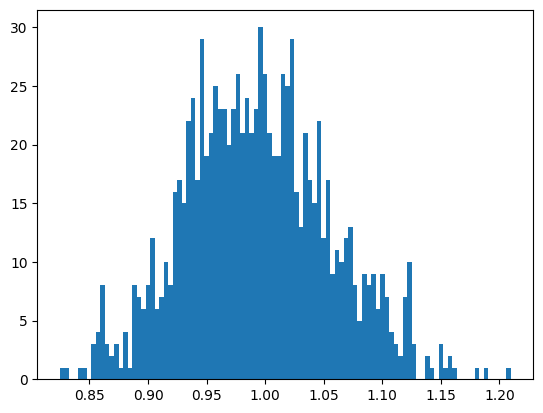

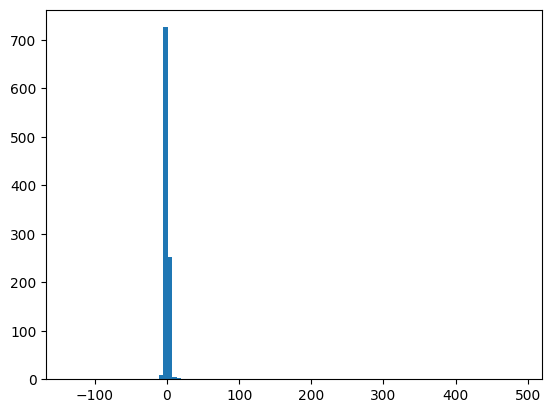

In [419]:
plt.hist(np.array(ske), bins = 100)
plt.show()
plt.hist(np.array(kur), bins = 100)
plt.show()

In [263]:
torch.cat([torch.max(x, -1)[0], torch.max(x, -1)[0]])

tensor([3.0457, 2.6082, 3.0457, 2.6082])

In [280]:
a = torch.mean(x, -1)
a[0]

tensor(-0.0383)

In [307]:
skew(a, -1)

array([-0.39085514])

In [432]:
a = np.random.randn(2,128)
x= torch.Tensor(a)

In [446]:
torch.sum(torch.pow((x - torch.mean(x,-1).reshape(2, 128)/torch.std(x, -1)), order) ,-1)

RuntimeError: shape '[2, 128]' is invalid for input of size 2